In [1]:
import matplotlib.pyplot as plt
import imageio
from skimage.feature import match_template
import numpy as np

__Exercise 1__

In [7]:
ball = imageio.get_reader('images/ball2.mp4')

OSError: No such file: '/home/steven/Documents/School/bb/images/ball2.mp4'

We first define "template", which is the image of the actual object we're trying to find inside a frame. In our case this will be the ball. 

In [ ]:
x1 = 75; y1 = 275
x2 = 120; y2 = 320

ball_40 = ball.get_data(40)
template_ball = ball_40[y1:y2, x1:x2]
last_ball = ball.get_data(350)

plt.imshow(template_ball)
plt.axis('off')
plt.show()

Now, for each frame between 40 and 350 we are trying to find the above ball. For each frame we use match_template to find this ball, while match_template will return and array of information about the position of where the ball might be. 

In [ ]:
begin_frame = 40
end_frame = 350
frame_rate = 10

In [ ]:
xs = np.array([])
ys = np.array([])

for i in np.arange(begin_frame, end_frame, frame_rate):
    im = ball.get_data(i)
    result = match_template(im, template_ball)
    y, x, _ = np.unravel_index(np.argmax(result), result.shape)
    xs = np.append(xs, x)
    ys = np.append(ys, y)
    print(x, y)

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(last_ball)
plt.scatter(xs, ys, edgecolors='none')
plt.show()

In the image above we can see a blue dot for the location of the ball in different frames. 

__Exercise 2__

To remake match_template we've choosen different design options. First of all we decided to split up the mask matrix into to vectors for the correlation, which should speed up the process. We're also working with a greyscale image for the same reason. However the code should also work for a RGB image (with some minor changes to the code).

In [ ]:
from skimage import color

In [ ]:
ball_40_grey = color.rgb2gray(ball_40)
template_grey = ball_40_grey[y1:y2, x1:x2]

plt.imshow(ball_40_grey, cmap="gray")
plt.axis('off')
plt.show()

We're using Scipy's correlate2d, since we are using a 2d correlation. We are also using mode "valid" This mode excludes points which rely on the zero-padding. Therefore the output doesn't have the weird border.

For den_1 and den_2 it doesn't matter if we are using a correlation or a convolution since the mask vectors are only containing 1's.

In [3]:
import scipy as sp

In [4]:
def my_match_template(f, template):    
    m = (template - np.mean(template)) / np.std(template)
    mask = np.ones((1, template.shape[0]))

    nom = sp.signal.correlate2d(f, m, mode='valid')
    
    den_1 = sp.signal.correlate2d(np.square(f), mask, mode='valid')
    den_1 = sp.signal.correlate2d(den_1, mask.T, mode='valid')
    
    den_2 = sp.signal.correlate2d(f, mask, mode='valid')
    den_2 = sp.signal.correlate2d(den_2, mask.T, mode='valid')

    return nom / np.sqrt(den_1 - np.square(den_2) / template.size)    

In [5]:
# xs = np.empty([(end_frame - begin_frame) / frame_rate])

xs2 = np.array([])
ys2 = np.array([])

for i in np.arange(begin_frame, end_frame, frame_rate):
    frame = color.rgb2gray(ball.get_data(i))
    result = my_match_template(frame, template_grey)
    y, x = np.unravel_index(np.argmax(result), result.shape)
    xs2 = np.append(xs2, x)
    ys2 = np.append(ys2, y)
    print(x, y)

NameError: name 'begin_frame' is not defined

The visualization of our implementation of match_template can be seen above. Now we are going to compare our implementation and scipy's version:

In [6]:
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(last_ball)
plt.scatter(xs, ys, label='original', edgecolors='none')
plt.scatter(xs2, ys2, label='my version', color='red', edgecolors='none')
plt.legend()
plt.show()

NameError: name 'last_ball' is not defined

In the plot we can barely see any difference between our implementation (red) vs match_template from sklearn (blue). To see if there really is no difference we can use the mean squared error, which shows us there is a very small error nevertheless.

In [37]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(np.column_stack((xs2, ys2)), np.column_stack((xs, ys))))

0.274193548387


__Exercise 3__

In [7]:
mouse = imageio.get_reader('mousemovie.mp4')

For the mouse movement we are trying to detect the movement of one template inside two frames.

In the first frame, we define our template which is in the center of our frame and thus its position is known. In the second frame we try to find this template. When we know the position of the template in the new frame we can detect the movement by checking the difference between the new position and the old position. This gives us the movement of the mouse between two frames.

In [8]:
def track_movement(mov):
    dx = np.array([])
    dy = np.array([])
    
    x1 = 12; y1 = 12 # define center?
    x2 = 20; y2 = 20
    
    frame = mov.get_data(0)    
    temp = frame[y1:y2, x1:x2]

    for i in range(1, mov.get_length()):
        frame = mov.get_data(i)
        
        result = match_template(frame, temp)
        
        y, x, _ = np.unravel_index(np.argmax(result), result.shape)
        dx = np.append(dx, x1 - x)
        dy = np.append(dy, y1 - y)        
        temp = frame[y1:y2, x1:x2]
        
    return dx, dy

The returned values are the differences of the movement between two frames. One for the x-values and one for the y-values:

In [9]:
dx, dy = track_movement(mouse)

print(np.column_stack((dx, dy))[:5])

[[-1.  4.]
 [ 0.  4.]
 [ 0.  5.]
 [-1.  4.]
 [ 0.  5.]]


Assuming our first point is (0, 0), we can see that the mouse moved 1 up and 4 to the left, therefore the new point will be (1, -4). Now we check the second point in our list, which will be added to our last point: (1, -4) + (0, -4) = (0, -8), etc.

When the movement is plotted we the movement forms an oval:

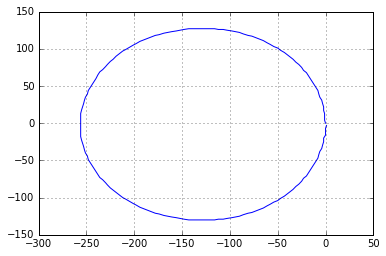

In [31]:
plt.plot(np.insert(np.cumsum(dx), 0, 0), np.insert(np.cumsum(dy), 0, 0))
plt.grid()
plt.show()